In [1]:
import numpy as np
import pandas as pd
import re

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import classification_report,confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import PreTrainedTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from tqdm import tqdm
import time


## Prerequisits

* make sure to download and unzip the data files (train,test,test_labels) from [this link]()
* it's recommended that you creata a new `conda environment` by running `conda env --name ENV_NAME` replacing the `ENV_NAME` with a name of your choice, and install the `requirments.txt` by executing `pip install -r requirments.txt`
* ℹ️ if you don't want to train the model from scratch, download the `pretrained_bilstm_attn` model from [here](https://drive.google.com/file/d/1NsO26I_VTvnqiJFAVA8J7zECZCB8ONI7/view?usp=sharing)


## 1. Explanatory Data Analysis

visualize the data and understand the distributions 

 ### importing the data from the csv files

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
y_true = pd.read_csv('test_labels.csv')

 ### have an idea about the length of the comments strings

In [4]:
train_df['comment_text'].apply(lambda x:len(x.split())).max()

1411

### get the column names for the target variables 
these will be used later to create the train,dev and test dataset

In [5]:
cols_target = train_df.columns[2:].tolist()

### Understanding the data shape and description

In [6]:
train_df.sample(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
40740,6cbb5277a91ed077,Mr. Viligante! \n\nDear Mr. Ioeth whateverthef...,1,0,1,0,1,0
103830,2b813ab782d34984,Important note \n\nDIE.,0,0,0,0,0,0
139458,ea714f84e062c442,The article did include his real name and it i...,0,0,0,0,0,0
69633,ba46606ee091e83b,"""\nThx. Someone put it on Family of Barack Oba...",0,0,0,0,0,0
128559,af92f1e2f4c42372,"""\nI apoligize for not being able to be """"full...",0,0,0,0,0,0
107815,4043aec662bda17c,listen peeps................this guy is one of...,0,0,0,0,0,0
71291,bed529ce6cb780a8,This addition is just as misleading as the sum...,0,0,0,0,0,0
156348,cccd45d35c7cd352,your tendancies to be editor of financial topi...,0,0,0,0,0,0
153271,9a204083856a48c1,fair enough. i'll go hide in a hole. good luck...,0,0,0,0,0,0
91919,f5bc78ba654ab185,Nagorno Karabakh \n\nThe following resource de...,0,0,0,0,0,0


In [7]:
# check missing values in numeric columns
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### checkout the negative labels percentage in the dataset

In [8]:
unlabelled_in_all = train_df[(train_df['toxic']!=1) & (train_df['severe_toxic']!=1) & (train_df['obscene']!=1) & 
                            (train_df['threat']!=1) & (train_df['insult']!=1) & (train_df['identity_hate']!=1)]
print('Percentage of unlabelled comments is ', len(unlabelled_in_all)/len(train_df)*100)

Percentage of unlabelled comments is  89.83211235124176


### check if and row doet not have comment_text 

In [9]:
no_comment = train_df[train_df['comment_text'].isnull()]
len(no_comment)

0

In [10]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [11]:
no_comment = test_df[test_df['comment_text'].isnull()]
no_comment

,id,comment_text


### checking the labels and rows counts 

In [12]:
print('Total rows in test is {}'.format(len(test_df)))
print('Total rows in train is {}'.format(len(train_df)))
print(train_df[cols_target].sum())

Total rows in test is 153164
Total rows in train is 159571
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


### visualize the labels distribution (i.e. the amount of 1s and 0s)

In [13]:
barplt_df = train_df[cols_target].apply(pd.Series.value_counts)

<AxesSubplot:>

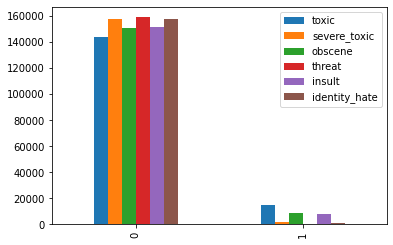

In [14]:
barplt_df.plot(kind='bar')

### getting the average character length for the comments in the dataset

In [15]:
train_df['char_length'] = train_df['comment_text'].apply(lambda x: len(str(x)))


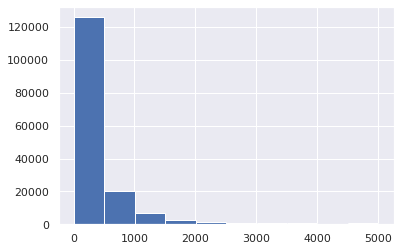

In [16]:
# look at the histogram plot for text length
sns.set()
train_df['char_length'].hist()
plt.show()

In [17]:
print("avg char length {}".format(sum(train_df['char_length'])/len(train_df['char_length'])))

avg char length 394.0732213246768


## 2. Deep Learning part (BiLSTM with Attention)


the structure of the model is shown below, a BiLSTM with Attention model was used to implement this task of multi-label classification



#### Notes on the model

* although the model achieves good accuracy in predicting each label in the dataset, other hpyerparameter and modifications might be required to make it better. (adding drop, decreasing the complexity etc..)
* The attention layer performs poorly to detect the part the might trigger a label.
* ⚠️ The task was to create a model that highlights each part of the comment that is responsible for each label predicted, however; i didn't understand this instead this model only focuses on the entire string and try to focus on all the parts that might be important to predict a label. This requested model might be created using a Multi-Headed Attention model (i'm still working on developing the model)
* ⚠️ the dimenions in the figure doesn't match the trained model below, however the structure is the same, it was changed because the dimensions in the figure below caused the model to overfit

<img src="./bilstm_attn.jpeg" width="800" >

 ### Preprocessing 
 
the tokenizer `PreTrainedTokenizerFast` was used to tokenize and transform the sequences into integer sequences which we will use later to index and Embedding Matrix 

In [21]:
def camel_case_split(identifier):
    """this function splits CamelCased words and return them to the tokenizer"""
    matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', identifier)
    return [m.group(0) for m in matches]

In [35]:
tokenizer = PreTrainedTokenizerFast.from_pretrained('bert-base-uncased')


In [36]:
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

0

In [24]:
def prepare_set(dataset, max_length=64):
    """returns input_ids, input_masks, labels for set of data ready in BERT format"""
    global tokenizer
    
    input_ids = dataset
#     for i in tqdm(dataset):
#         input_ids.append(camel_case_split(i))
    tokenized = tokenizer.batch_encode_plus(input_ids,return_token_type_ids=False, return_attention_mask=False, pad_to_max_length=True,truncation=True, max_length=max_length)["input_ids"]
    return tokenized

### hyperparameters


In [25]:
max_length = 64
hidden_size=128
tokenizer = None
batch_size = 32
n_epochs = 4
embed_size = 100
lr = 0.001
model_path = "BiLSTM.pt"
use_gpu = True
dev_size = int(train_df.shape[0] * 0.10)

### checking if there exists a GPU on the machine to use it


In [26]:
#device config
device =  torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')

In [27]:
class Attention(nn.Module):
    """a Single Attention Layer"""
    def __init__(self, feature_dim):
        super(Attention, self).__init__()
        
        self.supports_masking = True
        self.feature_dim = feature_dim
        weight = torch.zeros(feature_dim, 1)
        nn.init.xavier_uniform_(weight)
        self.weight = nn.Parameter(weight)
    
    def forward(self, x, step_dim, mask=None):
        feature_dim = self.feature_dim
        eij = torch.mm(
            x.contiguous().view(-1, feature_dim), self.weight
        ).view(-1, step_dim)
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        if mask is not None:
            a = a * mask
        a = a / torch.sum(a, 1, keepdim=True) + 1e-10
        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1), torch.unsqueeze(a, -1)


class BiLSTMWithAttention(nn.Module):
    """the BiLSTM model refer to the image above to understand the structure of the model"""
    def __init__(self,hidden_size,embed_size,max_features,num_classes,max_length):
        super().__init__()
        self.embedding = nn.Embedding(max_features, embed_size)
        
#         self.embedding_dropout = dropout.SpatialDropout(0.3)
        
        self.lstm1 = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        
        self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, bidirectional=True, batch_first=True)
        
        self.lstm_attention = Attention(hidden_size * 2)
        
        self.linear1 = nn.Linear(768, 768)
        self.linear2 = nn.Linear(768, 768)
        
        self.linear_out = nn.Linear(768, 1)
        self.linear_aux_out = nn.Linear(768, num_classes)
    
    def forward(self, x, step_len):
        h_embedding = self.embedding(x)
#         print(f"h_emdedding size : {h_embedding.shape}")
#         h_embedding = self.embedding_dropout(h_embedding)
        h_lstm1, _ = self.lstm1(h_embedding)
#         print(f"lstm1 size : {h_lstm1.shape}")
        h_lstm2, _ = self.lstm2(h_lstm1)
#         print(f"lstm2 size : {h_lstm2.shape}")
        #Attention layer
        h_lstm_atten, weights = self.lstm_attention(h_lstm2, max_length)
#         print(f"h_lstm , w sizes : {h_lstm_atten.shape}, {weights.shape}")
        # global average pooling
        avg_pool = torch.mean(h_lstm2, 1)
#         print(f"avg pool : {avg_pool.shape}")
        # global max pooling
        max_pool, _ = torch.max(h_lstm2, 1)
#         print(f"max pool : {max_pool.shape}")
        h_conc = torch.cat((h_lstm_atten, max_pool, avg_pool), 1)
#         print(f"h_conc : {h_conc.shape}")
        h_conc_linear1 = F.relu(self.linear1(h_conc))
#         print(f"h_conc_linear1 : {h_conc_linear1.shape}")
        h_conc_linear2 = F.relu(self.linear2(h_conc))
#         print(f"h_conc_linear2 : {h_conc_linear2.shape}")
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2
        result = self.linear_out(hidden)
#         print(f"result : {result.shape}")
        aux_result = self.linear_aux_out(hidden)
#         print(f"aux_result : {aux_result.shape}")
#         out = torch.cat([result, aux_result], 1)
#         print(f"out : {out.shape}")
#         return out, weights
        return aux_result, weights


### The training Loop

* mini batching was used to increase the performance
* because this is a multi-label classification problem, a proper criterion needed to be chosen, in this case it was BCEWithLogitsLoss (which is the BCE with sigmoid implemented internally)

In [31]:
def train_model(model, loss_fn, lr=0.001, batch_size=32, n_epochs=10,max_length=64):
    param_lrs = [{'params': param, 'lr': lr} for param in model.parameters()]
    optimizer = torch.optim.Adam(param_lrs, lr=lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.6 ** epoch)
    
    training_loss = []
    validation_loss = []
    
    best_loss = float("inf")
    for epoch in range(n_epochs):
        start_time = time.time()
        
        model.train()
        avg_loss = 0
        
        for data in tqdm(train_dataloader, disable=False):
            x_batch = data[:-1]
            y_batch = data[-1]

            y_pred, _ = model(*x_batch, max_length)
            
            loss = nn.BCEWithLogitsLoss()(y_pred,y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item() / len(train_dataloader)
            
        training_loss.append(avg_loss)
        model.eval()
        print(f'... Validating ... ')
        avg_val_loss = 0
        for val_data in tqdm(dev_dataloader, disable=False):
            x_batch = val_data[:-1]
            y_batch = val_data[-1]
        
            y_pred, _ = model(*x_batch, max_length)
            
            val_loss = nn.BCEWithLogitsLoss()(y_pred, y_batch)
            avg_val_loss += val_loss.item() / len(dev_dataloader)
        
        elapsed_time = time.time() - start_time
        validation_loss.append(avg_val_loss)
        if avg_val_loss < best_loss:
            print('saving the best model so far')
            best_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
        print(f'Epoch {epoch + 1}/{n_epochs}\t training_loss={avg_loss:.4f} \t validation_loss={avg_val_loss: 4f} \t time={elapsed_time:.2f}s')
        scheduler.step()
    return training_loss, validation_loss

### The evaulating/testing part

* each time a mini batch is run through the model and the corresponding weigts are saved and column-summed to get the count of True Positive labels

In [32]:
def evaluate(model):
    # Create the DataLoader for dev set.
    model.eval()
    preds = np.zeros((1,6))
    with torch.no_grad():
        for tst_data in tqdm(test_dataloader, disable=False):
            x_batch = tst_data[:-1]
            y_batch_labels = tst_data[-1].detach().cpu().numpy()
            
            y_pred, _ = model(*x_batch, max_length)
            
            y_pred_labels = (torch.sigmoid(y_pred).detach().cpu().numpy() > 0.5)
            
            correct_labels = (y_pred_labels == y_batch_labels)
            preds += correct_labels.sum(axis=0)
            
    return preds
            



### Preparing the datasets

* a portion specified by dev_size is taken from the training dataframe to be used as a dev set, this would help us after each epoch to see how our model is doing (i.e. generalizing the model)
* each data is tokenized and turned into sequence ids and converted into torch.tensors

In [37]:
train_df_cpy = train_df[dev_size:]
dev_df_cpy = train_df[:dev_size]
test_df_cpy = test_df
y_true_cpy = y_true

In [38]:
print("preprocessing training data...")
X_train = prepare_set(train_df_cpy['comment_text'].values.tolist())

print("preprocessing training data...")
X_dev = prepare_set(dev_df_cpy['comment_text'].values.tolist())

print("preprocessing test data...")
test_df = pd.merge(test_df_cpy,y_true_cpy,on='id')
# -1 labels mean that those lines were not used for the scoring 
test_df = test_df[test_df["toxic"] >= 0]

X_test = prepare_set(test_df['comment_text'].values.tolist())


preprocessing training data...


/home/madbulattif18/anaconda3/envs/myenv/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


preprocessing training data...
preprocessing test data...


/home/madbulattif18/anaconda3/envs/myenv/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [39]:
y_train = train_df_cpy[cols_target].values
y_dev = dev_df_cpy[cols_target].values
y_test = test_df[cols_target].values


x_train_torch = torch.tensor(X_train, dtype=torch.long).to(device)
x_dev_torch = torch.tensor(X_dev, dtype=torch.long).to(device)
x_test_torch = torch.tensor(X_test, dtype=torch.long).to(device)

# y_train_torch = torch.tensor(np.hstack([y_train, y_aux_train]), dtype=torch.float32).to(device)
y_train_torch = torch.tensor(y_train,dtype=torch.float).to(device)
y_dev_torch = torch.tensor(y_dev, dtype=torch.float).to(device)
# y_val_torch = torch.tensor(np.hstack([y_val, y_aux_val]), dtype=torch.float32).to(device)
y_test_torch = torch.tensor(y_test,dtype=torch.float).to(device)

### Creating dataloaders


In [40]:
# Create the DataLoader for training set
train_data = TensorDataset(x_train_torch, y_train_torch)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [41]:
# Create the DataLoader for dev set
dev_data = TensorDataset(x_dev_torch, y_dev_torch)
dev_sampler = RandomSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler=dev_sampler, batch_size=batch_size)

In [42]:
# Create the DataLoader for dev set.
test_data = TensorDataset(x_test_torch, y_test_torch)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [43]:
model = BiLSTMWithAttention(hidden_size=hidden_size,
                            embed_size=embed_size,
                            max_features=tokenizer.vocab_size,
                            num_classes=6,
                            max_length=max_length)
model.to(device)

BiLSTMWithAttention(
  (embedding): Embedding(30522, 100)
  (lstm1): LSTM(100, 128, batch_first=True, bidirectional=True)
  (lstm2): LSTM(256, 128, batch_first=True, bidirectional=True)
  (lstm_attention): Attention()
  (linear1): Linear(in_features=768, out_features=768, bias=True)
  (linear2): Linear(in_features=768, out_features=768, bias=True)
  (linear_out): Linear(in_features=768, out_features=1, bias=True)
  (linear_aux_out): Linear(in_features=768, out_features=6, bias=True)
)

### Training the model

if you want to train the model from scratch, umcomment the next cell, otherwise you might opt to load the pretrained model (link shown in the prerequsits)

In [45]:
#train_model(model=model,loss_fn=None,lr=lr,batch_size=batch_size,n_epochs=n_epochs,max_length=max_length)

  4%|▍         | 21/499 [00:00<00:02, 201.33it/s]

... Validating ... 


  0%|          | 5/4488 [00:00<01:33, 48.18it/s]

saving the best model so far
Epoch 1/4	 training_loss=0.0606 	 validation_loss= 0.053738 	 time=65.75s


  4%|▍         | 21/499 [00:00<00:02, 200.90it/s]

... Validating ... 


  0%|          | 4/4488 [00:00<01:56, 38.57it/s]

saving the best model so far
Epoch 2/4	 training_loss=0.0421 	 validation_loss= 0.045444 	 time=65.29s


  4%|▍         | 19/499 [00:00<00:02, 189.81it/s]

... Validating ... 


  0%|          | 5/4488 [00:00<01:40, 44.76it/s]

Epoch 3/4	 training_loss=0.0341 	 validation_loss= 0.048474 	 time=73.19s


  4%|▍         | 21/499 [00:00<00:02, 200.89it/s]

... Validating ... 


100%|██████████| 499/499 [00:02<00:00, 203.46it/s]

Epoch 4/4	 training_loss=0.0267 	 validation_loss= 0.051875 	 time=65.60s


([0.06061140655270359,
  0.042105396785314705,
  0.034075382167296754,
  0.026715138823414936],
 [0.0537381234853146,
  0.045444340547285425,
  0.04847354499161486,
  0.051875007179596554])

In [17]:

model.load_state_dict(torch.load(model_path))
model.to(device)

BiLSTMWithAttention(
  (embedding): Embedding(30522, 100)
  (lstm1): LSTM(100, 128, batch_first=True, bidirectional=True)
  (lstm2): LSTM(256, 128, batch_first=True, bidirectional=True)
  (lstm_attention): Attention()
  (linear1): Linear(in_features=768, out_features=768, bias=True)
  (linear2): Linear(in_features=768, out_features=768, bias=True)
  (linear_out): Linear(in_features=768, out_features=1, bias=True)
  (linear_aux_out): Linear(in_features=768, out_features=6, bias=True)
)

In [116]:
true_positives = evaluate(model)

100%|██████████| 2000/2000 [00:09<00:00, 217.86it/s]


In [129]:
for i,acc in enumerate((true_positives / test_df.shape[0])[0]):
    print(f"{cols_target[i]} accuracy is {acc*100:.2f}%")

toxic accuracy is 91.68%
severe_toxic accuracy is 99.40%
obscene accuracy is 96.02%
threat accuracy is 99.71%
insult accuracy is 96.41%
identity_hate accuracy is 99.09%


In [146]:
rgb_color_arr = [(162, 155, 254),(223, 230, 233),
                 (129, 236, 236),(0, 206, 201),
                 (250, 177, 160),(255, 234, 167),
                 (250, 177, 160),(253, 203, 110),
                 (225, 112, 85), (99, 110, 114)]

In [55]:
def get_color_escape(r, g, b, background=False):
    return '\033[{};2;{};{};{}m'.format(48 if background else 38, r, g, b)

In [59]:
def colorText(token,red,green,blue):
    return get_color_escape(0, 0, 0) + get_color_escape(red, green, blue, True)+ token + '\033[0m'

In [198]:
def predict_user_input():
    while True:
        with torch.no_grad():
            str = input("Enter a String:")
            if str == 'quit':
                break
            input_ids = prepare_set([str])
            single_x = torch.tensor(input_ids,dtype=torch.long).to(device)
            ys, attention_w = model(single_x,max_length)
            
            ys = torch.sigmoid(ys).detach().cpu().numpy().flatten()
            attention_w = attention_w.detach().cpu().numpy().flatten()
            
            decoded_str = tokenizer.decode(*input_ids).split()

            attention_ids = [decoded_str.index(w) for w in decoded_str if (w != "[CLS]" and w != "[SEP]" and w != "[PAD]")]
            
            print(f"original text: {str}")
            
            highlighted_str = []
            color_index = 0

            for _id in attention_ids:
                if attention_w[_id] > 0.035:
                    highlighted_str.append(colorText(decoded_str[_id]
                                                   ,rgb_color_arr[color_index][0]
                                                   ,rgb_color_arr[color_index][1]
                                                   ,rgb_color_arr[color_index][2]))
        
                else:
                    highlighted_str.append(decoded_str[_id])
                color_index+=1
                if(color_index>=10):
                    color_index=0
            
            print(f"String after attention and multi-label classification: { ' '.join(highlighted_str)}")
            print("labels: =======")
            print(', '.join('"{0}:{1:.2f}%"'.format(cols_target[i],(w*100)) for i,w in enumerate(ys)))
            print("\n")

In [199]:
predict_user_input()

Enter a String:the writer should quit his job and kill himself
original text: the writer should quit his job and kill himself
[0.01462905 0.02015642 0.01929706 0.04071356 0.04440593 0.0275556
 0.02992115 0.064064   0.03321201]
String after attention and multi-label classification: the writer should quit his job and kill himself
labels: =======
"toxic:41.58%", "severe_toxic:0.40%", "obscene:1.31%", "threat:6.84%", "insult:3.13%", "identity_hate:1.59%"


Enter a String:quit
